In [1]:
import pandas as pd
from sqlalchemy import create_engine
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/karysoares/Documents/book-reviews/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
engine = create_engine('sqlite:///books.db')

books_review = pd.read_sql('SELECT * FROM books_review', engine)
books_data = pd.read_sql('SELECT * FROM books_data LIMIT 10000', engine)

books_data['authors'] = books_data['authors'].apply(lambda x: eval(x) if isinstance(x, str) else None)

books_data['categories'] = books_data['categories'].apply(lambda x: eval(x) if isinstance(x, str) else None)


In [3]:
books_data_cleaned = books_data.dropna()

In [4]:
books_review_cleaned = books_review.dropna()

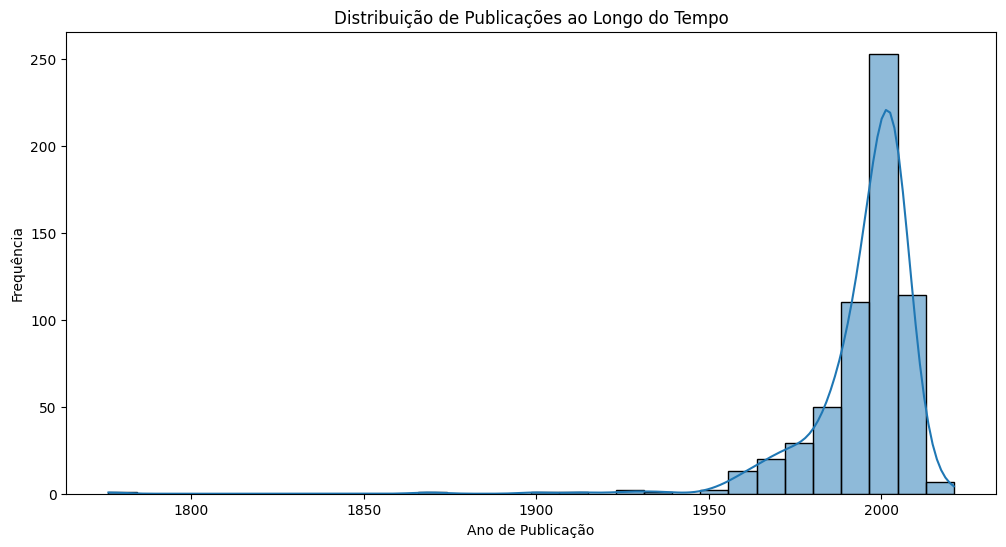

In [32]:
# Análise Temporal - Distribuição de Avaliações ao Longo do Tempo
plt.figure(figsize=(12, 6))
books_data['publishedDate'] = pd.to_datetime(books_data['publishedDate'], errors='coerce')
books_data['publishedYear'] = books_data['publishedDate'].dt.year
sns.histplot(books_data_cleaned['publishedYear'].dropna(), bins=30, kde=True)
plt.title('Distribuição de Publicações ao Longo do Tempo')
plt.xlabel('Ano de Publicação')
plt.ylabel('Frequência')
plt.show()

/tmp/ipykernel_640165/2087711412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_review_cleaned['sentiment'] = books_review_cleaned['summary'].apply(lambda x: TextBlob(x).sentiment.polarity)


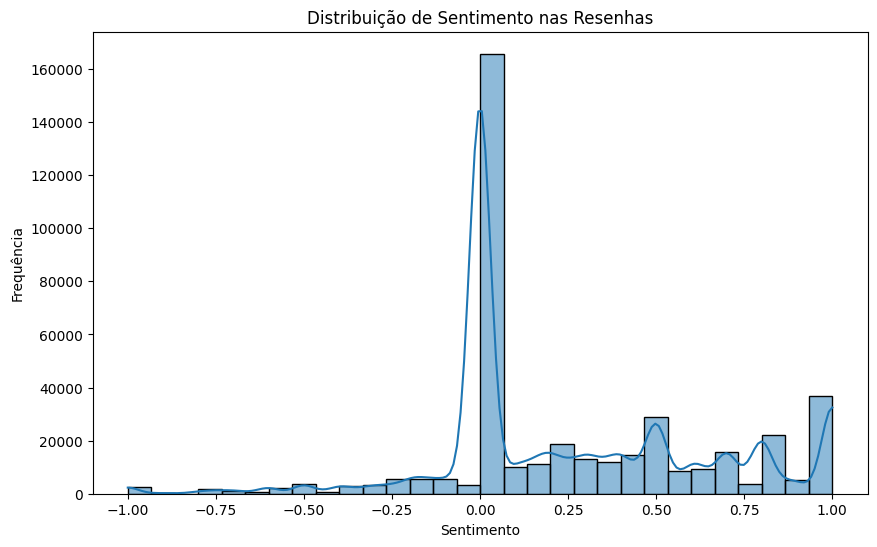

In [34]:
from textblob import TextBlob

books_review_cleaned['sentiment'] = books_review_cleaned['summary'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
sns.histplot(books_review_cleaned['sentiment'], bins=30, kde=True)
plt.title('Distribuição de Sentimento nas Resenhas')
plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.show()

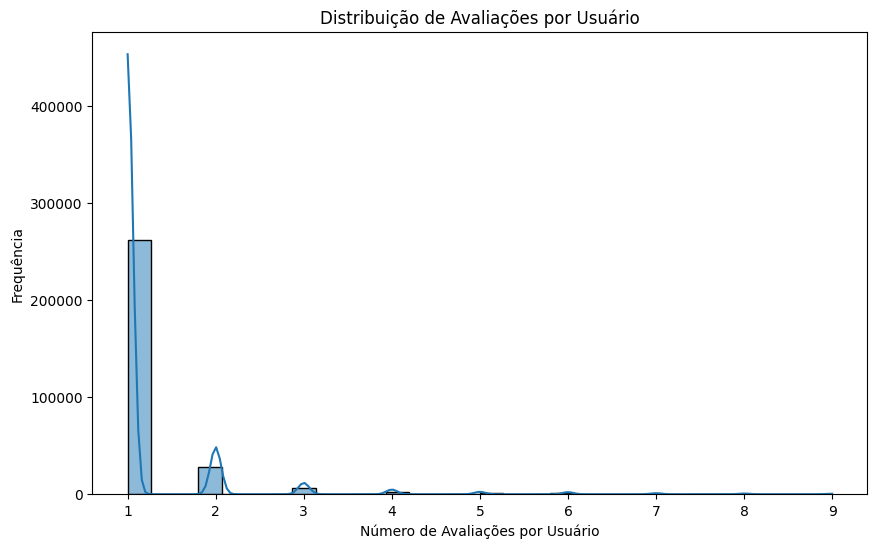

In [21]:
# 6. Análise de Distribuição de Avaliações por Usuário
user_ratings_count = books_review_cleaned['User_id'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count[user_ratings_count < 10], bins=30, kde=True) 
plt.title('Distribuição de Avaliações por Usuário')
plt.xlabel('Número de Avaliações por Usuário')
plt.ylabel('Frequência')
plt.show()

In [24]:
#  7. Análise de Tópicos com LDA
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(books_review_cleaned['summary'].dropna())

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# 8. Análise de Relevância das Resenhas - Comprimento da Resenha vs. Avaliação
books_review_cleaned['review_length'] = books_review_cleaned['summary'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='score', data=books_review_cleaned)
plt.title('Comprimento da Resenha vs. Avaliação')
plt.xlabel('Comprimento da Resenha (número de palavras)')
plt.ylabel('Avaliação')
plt.show()

# 9. Nuvem de Palavras para Resenhas Positivas e Negativas
positive_reviews = " ".join(review for review in books_review_cleaned[books_review_cleaned['sentiment'] > 0]['summary'])
negative_reviews = " ".join(review for review in books_review_cleaned[books_review_cleaned['sentiment'] < 0]['summary'])

wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(background_color='black').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Resenhas Positivas')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Resenhas Negativas')

plt.show()

KeyboardInterrupt: 